In [9]:
%matplotlib inline

In [40]:
# Import python modules
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import netCDF4
import gc, sys, os
sys.path.append("../scripts")
import spatial_functions
import aem_utils
import netcdf_utils
import modelling_utils
import plotting_functions as plots
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
# Dash dependencies
import plotly.express as px
from jupyter_dash import JupyterDash
from dash.dependencies import Input, Output
import dash_core_components as dcc
import dash_html_components as html
import dash_table


Import the LCI


In [11]:
# The actual inversoin data are stored on disk as netcdf files. NetCDF is an efficient format for storing 
# self-describing containerised data. 
# The implementation of netcdf for AEM line data was done by Alex Ip using his geophys_utils package.
# https://github.com/GeoscienceAustralia/geophys_utils/tree/master/geophys_utils


root = r"C:\Users\symin\OneDrive\Documents\GA\AEM\LCI"

# Define path to the netcdf file
infile = os.path.join(root, "SouthernStuart_WB_MGA53.nc")

# Create an instance
lci = aem_utils.AEM_inversion(name = 'Laterally Contrained Inversion (LCI)',
                              inversion_type = 'deterministic',
                              netcdf_dataset = netCDF4.Dataset(infile))

# As these inversions have already been gridded we will add these raster datasets to the instance using the
# load_lci_layer_grid() function. This function belongs to the AEM_inversion class.

# Directory in which the grids are located
infile = os.path.join(root, "grids\\SSC_LCI_layer_grids.p")

# Run function
lci.load_lci_layer_grids_from_pickle(infile)

# Create polylines
lci.create_flightline_polylines()

Create an instance of the garjmcmctdem inversion and probe the results using the same syntax as above.

In [12]:
# Path to netcdf file
infile = r"C:\Users\symin\OneDrive\Documents\GA\AEM\rjmcmc\SSC_vanilla_rjmcmc_pmaps.nc"


# Create instance
rj = aem_utils.AEM_inversion(name = 'GARJMCMCTDEM',
                             inversion_type = 'stochastic',
                             netcdf_dataset = netCDF4.Dataset(infile))

In [13]:
# Now we have the lines we can grid the lci conductivity data onto vertical grids (known as sections)
# this is the easiest way to visualise the AEM conuctivity in 2-dimensions

# Assign the lci variables to grid
grid_vars = ['conductivity', 'data_residual', 'depth_of_investigation']


# Define the resolution of the sections
xres, yres = 40., 5.

# We will use the lines from the rj

lines = rj.data['line'][:]

# Define the output directory if saving the grids as hdf plots

hdf5_dir = r"C:\Temp\SSC_hdf5"

# if the directory doesn't exist, then create it
if not os.path.exists(hdf5_dir):
    os.mkdir(hdf5_dir)  

# Gridding takes a few minutes so I pre-gridded them for you. The lci.grid_sections()
# function below will do the gridding for you. Instead we will use the load_sectoin_from_file()
# function, which loads hdf5 files produced using the grid_sections() function


#lci.grid_sections(variables = grid_vars, lines = lines, xres = xres, yres = yres,
#                  return_interpolated = True, save_hdf5 = True, hdf5_dir = hdf5_dir)

lci.load_sections_from_file(hdf5_dir, grid_vars, lines = lines)

In [14]:
# Grid the rj sections

# Assign the lci variables to grid
grid_vars = ['conductivity_p10', 'conductivity_p50', 'conductivity_p90', 'interface_depth_histogram']

# Define the resolution of the sections
xres, yres = 100., 2.

# We will use the lines from the rj

lines = np.unique(rj.data['line'][:].astype('int'))

# Define the output directory if saving the grids as hdf plots

hdf5_dir = r"C:\Temp\SSC_hdf5_rj"

# if the directory doesn't exist, then create it
if not os.path.exists(hdf5_dir):
    os.mkdir(hdf5_dir)  

#rj.grid_sections(variables = grid_vars, lines = lines, xres = xres, yres = yres,
#                  return_interpolated = True, save_hdf5 = True, hdf5_dir = hdf5_dir)

rj.load_sections_from_file(hdf5_dir, grid_vars, lines = lines)

# 2. Visualise the data


# 2.1 Map plot

Our first standard plot is an plot of gridded conductivity with the points inverted with GARJMCMCTDEM
plotted as points.

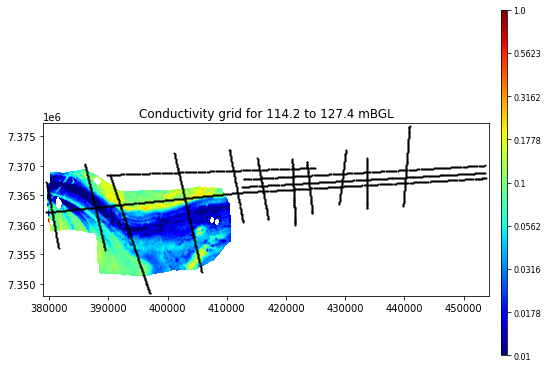

In [15]:
       
# In this notebook, standard plot key word arguments are passed to the plotting function as a python dictionary

# Here we explain each variable. Feel free to change and regenerate the plot
plot_args = {'Layer_number': 15, # Which AEM layer grid to plot from layer 1 (shallowest) to 30 (deepest)
             "figsize": (8,8), # The figure size in inches
             "vmin": 0.01, "vmax": 1., # The maximum and minimum conductivities in (S/m) for the grid colourstretch
             "point_size": 1, "point_colour": 'black', # Size and colour of the scatter plot points
             'colour_stretch': 'jet', # See matplotlib colourstretches
             'buffer': 500.} # The plot boundary will be buffered around the outer most scatter points.

#plt.close('all')
# Do some plotting

fig, ax, cax = plots.AEM_baseplot(rj, lci, plot_args = plot_args)


plt.show()



# 2.2 Section plot

Our next standard plot is a vertical AEM section. The rather irregular length of sections means these are
commonly customised. As such we have left it to the user to define the size of the panels.


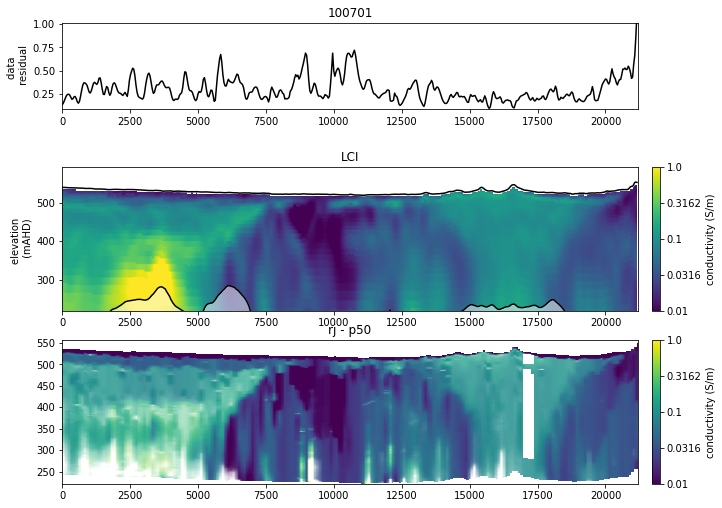

In [16]:
# Composite plot
plt.close('all')
fig = plt.figure(figsize = (10,8))

# Add two axes for the data misfit and the conductivity
# 
ax1 = fig.add_axes([0.1, 0.75, 0.8, 0.15])
ax2 = fig.add_axes([0.1, 0.4, 0.8, 0.25], sharex = ax1)
ax3 = fig.add_axes([0.1, 0.1, 0.8, 0.25], sharex = ax1)

# Add a color
cbar_ax2 = fig.add_axes([0.92, 0.4, 0.01, 0.25])
cbar_ax3 = fig.add_axes([0.92, 0.1, 0.01, 0.25])

panel_kwargs = [{'title': '',
                      'color': 'black',
                      'ylabel': 'data \n residual',
                      'legend': False,
                      },
                     {'max_depth': 300.,
                      'shade_doi': True,
                      'colourbar': True,
                      'colourbar_label': 'Conductivity (S/m)',
                      'log_plot': True,
                      'vmin': 0.01,
                      'vmax': 1.,
                      'cmap': 'viridis',
                      'ylabel': 'elevation \n (mAHD)'},
                     {'max_depth': 300.,
                      'shade_doi': False,
                      'colourbar': False,
                      'colourbar_label': 'Conductivity (S/m)',
                      'log_plot': True,
                      'vmin': 0.01,
                      'vmax': 1.,
                      'cmap': 'viridis',
                      'ylabel': 'elevation \n (mAHD)'}]

# define your line
line = lines[6]

res = plots.plot_single_line(ax1, lci.section_data[line],
                                   'data_residual', panel_kwargs[0])

lci_section = plots.plot_grid(ax2, lci.section_data[line], 'conductivity',
                           panel_kwargs[1])


vmin, vmax = panel_kwargs[2]['vmin'], panel_kwargs[2]['vmax']
cmap = panel_kwargs[2]['cmap']


colours = plots.array2rgba(rj.section_data, line, vmin, vmax, cmap,
                           upper_threshold = 0.9, lower_threshold = 0.1)

extent = (rj.section_data[line]['grid_distances'][0], rj.section_data[line]['grid_distances'][-1],
          rj.section_data[line]['grid_elevations'][-1], rj.section_data[line]['grid_elevations'][0])


rj_section = ax3.imshow(colours, aspect = 'auto',extent = extent,
                        vmin = np.log10(vmin), vmax= np.log10(vmax),
                       cmap = cmap)


cb2 = fig.colorbar(lci_section, cax=cbar_ax2, orientation='vertical')
    
cbar_ax2.set_yticklabels([round(10 ** x, 4) for x in cb2.get_ticks()])

cb2.set_label('conductivity (S/m)', fontsize=10)

cb3 = fig.colorbar(rj_section, cax=cbar_ax3, orientation='vertical')
    
cbar_ax3.set_yticklabels([round(10 ** x, 4) for x in cb3.get_ticks()])

cb3.set_label('conductivity (S/m)', fontsize=10)

ax1.set_title(str(line))
ax2.set_title('LCI')
ax3.set_title('rj - p50')

plt.show()

# 3 Setup your model

Now we want to create a model boundary object for our interpreted surface. The easiest way to manage this is to have a separate instance the module boundary for every interface. This will allow us to produce eggs ready output files as we go.

In [17]:
# Create an modelled boundary instance

headings = ["inversion_name",'X', 'Y', 'ELEVATION', "DEM", "DEPTH", "UNCERTAINTY", "Type",
            "BoundaryNm", "BoundConf", "BasisOfInt", "OvrConf", "OvrStrtUnt", "OvrStrtCod", "UndStrtUnt",
           "UndStrtCod", "WithinType", "WithinStrt", "WithinStNo", "WithinConf", "InterpRef",
            "Comment", "SURVEY_LINE", "Operator"]

interp_file = r"C:\temp\Mereenie-Pertnjara_interface_interpreted_points.csv"

MP_surface = modelling_utils.modelled_boundary(name = 'Mereenie-Pertnjara interface',
                                               outfile_path = interp_file,
                                               interpreted_point_headings = headings)




In [18]:
# Lets start with line doing every 5th point, going from 

line = lines[0]

line_inds = netcdf_utils.get_sorted_line_inds(rj.data, line, how = "north-south", subset = 2)


In [19]:
# Define the interative parameters
snap_window = 8
stdev_ceiling = 30.

# pmaps function
def pmap_click(eventydata):
    
    if eventydata != None:
        #We will use fiducial as a key
        depth, stdev = modelling_utils.click2estimate(D, eventydata,
                                                       snap_window = snap_window,
                                                       stdev_ceiling = stdev_ceiling)
        
        # append to the surface object interpreted points
        interp = {'fiducial': D['fiducial'],
                  'inversion_name': surface.Inversion_name,
                  'X': np.round(D['easting'],0),
                  'Y': np.round(D['northing'],0),
                  'DEPTH': np.round(depth,0),
                  'ELEVATION': np.round(D['elevation'] - depth,2),
                  'DEM': np.round(D['elevation'],0),
                  'UNCERTAINTY': np.round(stdev,0),
                  'Type': surface.Type,
                 'BoundaryNm': surface.name,
                 'BoundConf': surface.BoundConf,
                 'BasisOfInt': surface.BasisOfInt,
                 'OvrConf': surface.OvrConf,
                 'OvrStrtUnt': surface.OvrStrtUnt,
                 'OvrStrtCod': surface.OvrStrtCod,
                 'UndStrtUnt': surface.UndStrtUnt,
                 'UndStrtCod': surface.UndStrtCod,
                 'WithinType': surface.WithinType,
                 'WithinStrt': surface.WithinStrt,
                 'WithinStNo': surface.WithinStNo,
                 'WithinConf': surface.WithinConf,
                 'InterpRef': surface.InterpRef,
                 'Comment': surface.Comment,
                 'SURVEY_LINE': D['line'],
                 'Operator': surface.Operator,
                  "point_index": point_index
                   }
                               
        df = pd.DataFrame(interp, index = [0]).set_index('point_index', drop = True)

        try:
            surface.interpreted_points = surface.interpreted_points.append(df, verify_integrity = True)
        # Value error is if the point has already been interpreted
        except ValueError:
            surface.interpreted_points.loc[df.index, df.columns] = df.values[0]

        # Save the interpretation
        surface.interpreted_points.to_csv(surface.outfile_path)

In [20]:
# Next we define 
pmap_kwargs = {# Panel 1 is the 2d histogram of conductivity and depth.
               # Counts are converted to probabilities
               'panel_1': {'min_depth': 0,
                           'max_depth': 300.,
                           'cmap': 'rainbow',
                           'legend': True},
               # Panel 2 is the change point histogram panel. This shows
               # where we are most likely to have layer boundaries.
              'panel_2': {'auto_xlim': True,
                          'pmin': 0.002,
                          'pmax': 5.,
                         'legend': False},
               # panel 3 is the interpolated surface grid described above.
              'panel_3': {'vmin': -300,
                          'vmax': 0.},
               # panel 4 shows the misfit for our MCMC chains. This plot shows
               # if our model has converged
              'panel_4': {'misfit_min': 0.01,
                          'misfit_max': 1e4},
               # panel 5 shows the lci misft for a section.
              'panel_5': {'title': '',
                      'color': 'black',
                      'ylabel': 'data \n residual',
                      'legend': False,
                         'buffer': 5000.},
               # panel 6 shows the lci conducivity Section
              'panel_6': {'title': 'LCI conductivity',
                      'max_depth': 300.,
                      'vmin': 0.001,
                      'vmax': 1,
                      'cmap': 'viridis',
                      'ylabel': 'elevation \n (mAHD)',
                       'buffer': 5000.,
                       'shade_doi': True},
               # panel 7 shows the gridded AEM conductivity.
              'panel_7': {'Layer_number': 4,
                          "vmin": 0.001, "vmax": 1.,
                          'cmap': 'jet',
                          'buffer': 5000.}}


# Define your surface
surface = MP_surface

# Assign attributes base on what you want to be
# entered into the eggs database
surface.Type = "BASE_Cenozoic_TOP_Paleozoic"
surface.OvrStrtUnt = "Pertnjara Formation"
surface.OvrStrtCod = 15098
surface.UndStrtUnt = "Mereenie Sandstone"
surface.UndStrtCod = 11667
surface.Inversion_name = "garjmcmtdem"
surface.BoundConf = "M"
surface.BasisOfInt = "IAEM"
surface.OvrConf = "M"
surface.InterpRef = ""
surface.Comment = ""
surface.Operator = "Neil Symington"
surface.WithinType = ""
surface.WithinStrt = ""
surface.WithinStNo = ""
surface.WithinConf = ""

In [21]:
i = 5

This plot is for a pmap based interpretation

rj point index is  461
Fidicial is  631634.5


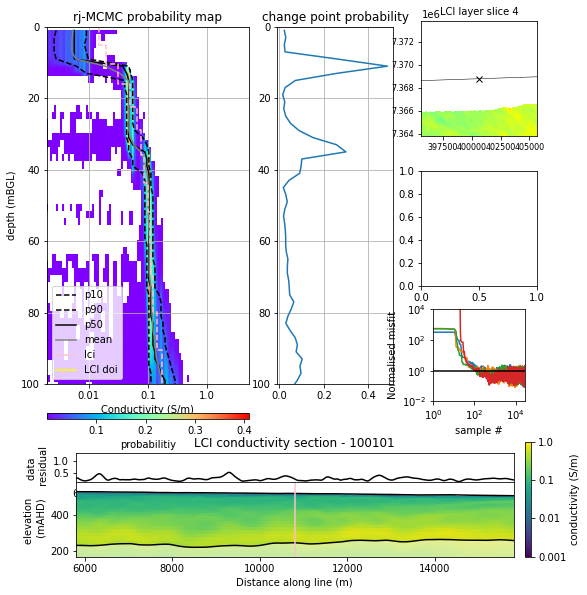

In [65]:
# Run the pmap interpretation again

plt.close('all')

# define our point from the points array using the index i
point_index = line_inds[i]

# Extract the data from the netcdf data
D = netcdf_utils.extract_rj_sounding(rj, lci, point_index)

# print the poit index and fiducial for our reference
print("rj point index is ", point_index)
print("Fidicial is ", D['fiducial'])

# create the figure
fig, ax_array = plots.pmap_plot(D, pmap_kwargs, surface, lci)

ax_array[0].set_ylim(100.,0)
ax_array[1].set_ylim(100.,0)

# show the plot
plt.show()

i+=10

In [67]:
pmap_click(12.)

In [23]:
# The point index is now the dataframe index
surface.interpreted_points = pd.read_csv(r"C:\temp\Mereenie-Pertnjara_interface_interpreted_points.csv",
                                         index_col = 0)
print(surface.interpreted_points)

     inversion_name         X          Y  ELEVATION    DEM  DEPTH  \
980     garjmcmtdem  423069.0  7369520.0     459.26  470.0   11.0   
1976    garjmcmtdem  419466.0  7369406.0     469.49  478.0    9.0   
1007    garjmcmtdem  417573.0  7369340.0     476.30  483.0    7.0   
151     garjmcmtdem  415681.0  7369274.0     480.30  489.0    9.0   
1533    garjmcmtdem  413792.0  7369217.0     497.29  498.0    1.0   
959     garjmcmtdem  411897.0  7369148.0     495.14  506.0   11.0   
83      garjmcmtdem  409985.0  7369089.0     498.08  509.0   11.0   
601     garjmcmtdem  408099.0  7369024.0     493.40  502.0    9.0   
1302    garjmcmtdem  404318.0  7368897.0     507.99  515.0    7.0   
461     garjmcmtdem  400628.0  7368772.0     520.87  524.0    3.0   

      UNCERTAINTY                         Type                    BoundaryNm  \
980           3.0  BASE_Cenozoic_TOP_Paleozoic  Mereenie-Pertnjara interface   
1976          3.0  BASE_Cenozoic_TOP_Paleozoic  Mereenie-Pertnjara interface   


Section plot interpretation

In [24]:
# section functions
def xy2fid(x,y, dataset):
    dist, ind = spatial_functions.nearest_neighbours([x, y],
                                                     dataset.coords,
                                                     max_distance = 100.)
    return dataset.data['fiducial'][ind][0]


def section_click(event):
    
    if event.xdata != None and event.ydata != None:

        min_idx = np.argmin(np.abs(lci.section_data[line]['grid_distances'] - event.xdata))
        
        easting = lci.section_data[line]['easting'][min_idx]
        northing = lci.section_data[line]['northing'][min_idx]
        elevation = lci.section_data[line]['elevation'][min_idx]
        depth =  elevation - event.ydata
        fid = xy2fid(easting,northing, lci)
        
        # append to the surface object interpreted points
        interp = {'fiducial': fid,
                  'inversion_name': surface.Inversion_name,
                  'X': np.round(easting,0),
                  'Y': np.round(northing,0),
                  'DEPTH': np.round(depth,0),
                  'ELEVATION': event.ydata,
                  'DEM': elevation,
                  'UNCERTAINTY': np.nan, # TODO implement
                  'Type': surface.Type,
                 'BoundaryNm': surface.name,
                 'BoundConf': surface.BoundConf,
                 'BasisOfInt': surface.BasisOfInt,
                 'OvrConf': surface.OvrConf,
                 'OvrStrtUnt': surface.OvrStrtUnt,
                 'OvrStrtCod': surface.OvrStrtCod,
                 'UndStrtUnt': surface.UndStrtUnt,
                 'UndStrtCod': surface.UndStrtCod,
                 'WithinType': surface.WithinType,
                 'WithinStrt': surface.WithinStrt,
                 'WithinStNo': surface.WithinStNo,
                 'WithinConf': surface.WithinConf,
                 'InterpRef': surface.InterpRef,
                 'Comment': surface.Comment,
                 'SURVEY_LINE': D['line'],
                 'Operator': surface.Operator,
                  "point_index": point_index
                   }
        df = pd.DataFrame(interp, index = [0]).set_index('fiducial')

        try:
            surface.interpreted_points = surface.interpreted_points.append(df, verify_integrity = True)
        # Value error is if the point has already been interpreted
        except ValueError:
            surface.interpreted_points.loc[df.index, df.columns] = df.values[0]

        # Save the interpretation
        surface.interpreted_points.to_csv(surface.outfile_path)

In [70]:
panel_kwargs = [{'title': '',
                      'color': 'black',
                      'ylabel': 'data \n residual',
                      'legend': False,
                      },
                     {'max_depth': 100.,
                      'shade_doi': True,
                      'colourbar': True,
                      'colourbar_label': 'Conductivity (S/m)',
                      'log_plot': True,
                      'vmin': 0.01,
                      'vmax': 1.,
                      'cmap': 'viridis',
                      'ylabel': 'elevation \n (mAHD)'},
                     {'max_depth': 100.,
                      'shade_doi': False,
                      'colourbar': False,
                      'colourbar_label': 'Conductivity (S/m)',
                      'log_plot': True,
                      'vmin': 0.01,
                      'vmax': 1.,
                      'cmap': 'viridis',
                      'ylabel': 'elevation \n (mAHD)'},
               {'max_depth': 100.,
                      'shade_doi': False,
                      'colourbar': False,
                      'colourbar_label': 'Conductivity (S/m)',
                      'log_plot': True,
                      'vmin': 0.01,
                      'vmax': 1.,
                      'cmap': 'viridis',
                      'ylabel': 'elevation \n (mAHD)'},
               ]


print(surface.name)

# Assign attributes base on what you want to be
# entered into the eggs database
surface.Type = "BASE_Cenozoic_TOP_Paleozoic"
surface.OvrStrtUnt = "Pertnjara Formation"
surface.OvrStrtCod = 15098
surface.UndStrtUnt = "Mereenie Sandstone"
surface.UndStrtUnt = 11667
surface.Inversion_name = "lci"
surface.BoundConf = "M"
surface.BasisOfInt = "IAEM"
surface.OvrConf = "M"
surface.InterpRef = ""
surface.Comment = ""
surface.Operator = "Neil Symington"
surface.WithinType = ""
surface.WithinStrt = ""
surface.WithinStNo = ""
surface.WithinConf = ""

# Define vertical exageration

vertical_exaggeration = 10.

Mereenie-Pertnjara interface


In [25]:
def vex2section_height(section_data, fig_width,
                       vertical_exaggeration,
                       section_kwargs,
                       height_fraction, width_fraction):
    ''' This function calculates the figure height so that
     a section will have a desired vertical exaggeration
    
     @param: section_data: dictionary
        section data for line of interest
     
     @param: fig_width: float
        the width in inches 
     
     @param: vertical_exaggeration: float
        the vertical exaggeration
        
     @param: section_kwargs: dictionary
        key word arguments for plotting section
     
     @param: height_fraction: float between 0 and 1
        fraction of the figure that will be the section
        in vertical direction
        
     @param: width_fraction: float between 0 and 1
        fraction of the width that will be the section
        in horizontal direction
        
    returns figure_height
    '''
    # Get the section veritcal height in metres
    min_elevation = np.min(section_data['elevation']) - section_kwargs['max_depth']
    max_elevation = section_data['grid_elevations'][0]
    max_elevation +=  0.1 * (section_data['grid_elevations'][0] - min_elevation)
    
    vert_distance = max_elevation - min_elevation
    
    #  Get the section distance in metres
    hor_distance = section_data['grid_distances'][-1]
    
    
    
    # Get section width in inches
    section_width = fig_width * width_fraction
    
    
    scale = section_width/hor_distance

    # Get the section height in inches
    section_height = vert_distance * scale * vertical_exaggeration
    
    # Return figure height using the fraction of figure that the section
    # takes up
    return section_height/ height_fraction


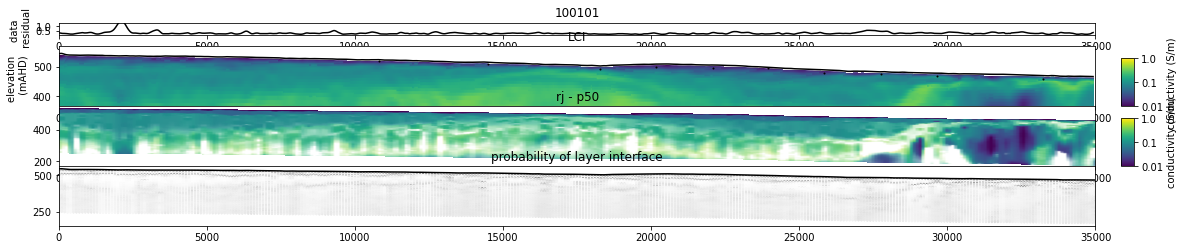

In [72]:
# Composite plot
plt.close('all')

# This section will calcul
width = 18.

height = vex2section_height(section_data = lci.section_data[line],
                            fig_width = width,
                            vertical_exaggeration = vertical_exaggeration,
                            section_kwargs = panel_kwargs[1],
                            height_fraction = 0.25, # See heigh in add_axes functoin
                            width_fraction = 0.8) # see width in add_axes function

fig = plt.figure(figsize = (width,
                            height))

# Add two axes for the data misfit and the conductivity
# 
ax1 = fig.add_axes([0.1, 0.9, 0.8, 0.05])
ax2 = fig.add_axes([0.1, 0.6, 0.8, 0.25], sharex = ax1)
ax3 = fig.add_axes([0.1, 0.35, 0.8, 0.25], sharex = ax1)
ax4 = fig.add_axes([0.1, 0.1, 0.8, 0.25], sharex = ax1)

# Add a color
cbar_ax2 = fig.add_axes([0.92, 0.6, 0.01, 0.2])
cbar_ax3 = fig.add_axes([0.92, 0.35, 0.01, 0.2])


res = plots.plot_single_line(ax1, lci.section_data[line],
                                   'data_residual', panel_kwargs[0])

lci_section = plots.plot_grid(ax2, lci.section_data[line], 'conductivity',
                              panel_kwargs[1])



vmin, vmax = panel_kwargs[2]['vmin'], panel_kwargs[2]['vmax']
cmap = panel_kwargs[2]['cmap']


colours = plots.array2rgba(rj.section_data, line, vmin, vmax, cmap,
                           upper_threshold = 0.9, lower_threshold = 0.2)

interpx, interpz, fids = spatial_functions.interp2scatter(surface, line, lci.section_data)

ax2.scatter(interpx, interpz, s = 1, c = 'k')

extent = (rj.section_data[line]['grid_distances'][0], rj.section_data[line]['grid_distances'][-1],
          rj.section_data[line]['grid_elevations'][-1], rj.section_data[line]['grid_elevations'][0])


rj_section = ax3.imshow(colours, aspect = 'auto',extent = extent,
                        vmin = np.log10(vmin), vmax= np.log10(vmax),
                        cmap = cmap)

ax4 = plots.layer_point_prob_plot(ax4, rj.section_data, line)


#ax4.set_ylim(rj.section_data[line]['elevation'].min() - panel_kwargs[3]['max_depth'],
#             rj.section_data[line]['elevation'].max() + 0.25*panel_kwargs[3]['max_depth'])


cb2 = fig.colorbar(lci_section, cax=cbar_ax2, orientation='vertical')
    
cbar_ax2.set_yticklabels([round(10 ** x, 4) for x in cb2.get_ticks()])

cb2.set_label('conductivity (S/m)', fontsize=10)

cb3 = fig.colorbar(rj_section, cax=cbar_ax3, orientation='vertical')
    
cbar_ax3.set_yticklabels([round(10 ** x, 4) for x in cb3.get_ticks()])

cb3.set_label('conductivity (S/m)', fontsize=10)

ax1.set_title(str(line))
ax2.set_title('LCI')
ax3.set_title('rj - p50')
ax4.set_title("probability of layer interface")


plt.show()

#cid =  fig.canvas.mpl_connect('button_press_event', section_click)

In [73]:
# here we export our interpreted points to a shapefile

#first create a geopandas dataframe
gdf =gpd.GeoDataFrame(surface.interpreted_points,
                      geometry=gpd.points_from_xy(surface.interpreted_points.X,
                                                  surface.interpreted_points.Y))

# Set the coordinate system
gdf.set_crs(epsg=28353, inplace=True)

outfile = r"C:\temp\Mereenie-Pertnjara_interface_interpreted_points.shp"

gdf.to_file(outfile)

In [47]:
def interp2scatter(line, gridded_data, interpreted_points, easting_col = 'X',
                   northing_col = 'Y', elevation_col = 'ELEVATION',
                   line_col = 'SURVEY_LINE'):

    mask = interpreted_points[line_col] == line
    utm_coords = np.column_stack((gridded_data[line]['easting'],
                                  gridded_data[line]['northing']))

    dist, inds = spatial_functions.nearest_neighbours(interpreted_points[mask][[easting_col,northing_col]].values,
                                                      utm_coords, max_distance=100.)

    grid_dists = gridded_data[line]['grid_distances'][inds]
    elevs = interpreted_points[mask][elevation_col].values
    fids = interpreted_points[mask].index
    return  grid_dists, elevs, fids

def dash_section(line, section_data, df_interp, colours):
    # Create the grid
    fig = px.imshow(img = np.log10(lci.section_data[line]['conductivity']),
                zmin = np.log10(0.001), zmax = np.log10(1.),
                x = lci.section_data[line]['grid_distances'],
                y = lci.section_data[line]['grid_elevations'],
        color_continuous_scale='viridis', aspect = 'auto'
    )

    interpx, interpz, fids = interp2scatter(line, section_data,
                                                              df_interp)

    labels = ["fiducial = " + str(x) for x in fids]

    fig.add_scatter(x = interpx,
                    y = interpz,
                    mode = 'markers',
                   hovertext = labels,
                    marker = {"color": colours})

    # Reverse y-axis
    fig.update_yaxes(autorange=True)

    return fig



In [50]:
# you may need extra dependencies to run these cells

app = JupyterDash(__name__)

df = surface.interpreted_points

app.layout = html.Div([
    html.H1("AEM Plotting Demo"),
    html.Div(id='section'),
    html.Div(dash_table.DataTable(id='interp_table',
                                    columns=[{"name": i, "id": i} for i in df.columns],
                                    data=df.to_dict('records'),
                                 fixed_columns={ 'headers': True, 'data': 1 },
                                 sort_action="native",
                                 sort_mode="multi",
                                 column_selectable="multi",
                                 row_selectable="multi",
                                 row_deletable=True,
                                 selected_columns=[],
                                 selected_rows=[],
                                 style_header={'backgroundColor': 'rgb(30, 30, 30)',
                                               'height': '70px'},
                                 style_cell={
                                     'backgroundColor': 'rgb(50, 50, 50)',
                                     'color': 'white',
                                     'minHeight': '50px',
                                     'minWidth': '0px', 'maxWidth': '500px',
                                     'whiteSpace': 'normal'
                                 },
                                  style_table={
                                              'maxHeight': '1000px',
                                              'overflowY': 'scroll',
                                              'maxWidth':  '1000px',
                                              'overflowX': 'scroll'})
             )
])


@app.callback(
    Output('section', "children"),
    [Input('interp_table', "derived_virtual_data"),
     Input('interp_table', "derived_virtual_selected_rows")])
def update_graphs(rows, derived_virtual_selected_rows):
    # When the table is first rendered, `derived_virtual_data` and
    # `derived_virtual_selected_rows` will be `None`. This is due to an
    # idiosyncrasy in Dash (unsupplied properties are always None and Dash
    # calls the dependent callbacks when the component is first rendered).
    # So, if `rows` is `None`, then the component was just rendered
    # and its value will be the same as the component's dataframe.
    # Instead of setting `None` in here, you could also set
    # `derived_virtual_data=df.to_rows('dict')` when you initialize
    # the component.
    if derived_virtual_selected_rows is None:
        derived_virtual_selected_rows = []

    dff = df if rows is None else pd.DataFrame(rows)

    colours = ['red' if i in derived_virtual_selected_rows else 'blue'
              for i in range(len(dff))]

    fig = dash_section(line, lci.section_data, dff, colours)

    return [
        dcc.Graph(
            id='graph',
            figure=fig
            ),
    ]

app.run_server(mode='external')



Dash app running on http://127.0.0.1:8050/


Dash app running on http://127.0.0.1:8050/
